# Word2Vec e Game of Thrones 
Neste notebook, faremos uma análise dos roteiros da série Game of Thrones utilizando Word2Vec. Este dataset pode ser encontrado [aqui](https://www.kaggle.com/anderfj/game-of-thrones-series-scripts-breakdowns) 

### Breve explicação
A suposição feita pelo word2vec é a de que duas palavras que compartilham contextos semelhantes, também irão compartilhar uma representação vetorial semelhante do modelo. Por exemplo, se palavras como "cachorrinho" e "fofo" forem frequentemente usadas em situações semelhantes, logo, essas mesmas palavras também terão vetores similares em sua representação segundo o word2vec. 

É através desta suposição que o word2vec consegue encontrar relações entre as palavras em um dataset, computar a similaridade entre elas e usar a sua representação em vetores para essas palavras como input para outras aplicações, como classificação de texto ou clustering. 

## Importando bibliotecas

In [1]:
import pandas as pd
import re 
from time import time
from collections import defaultdict 
import spacy 
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Pré-processamentos

In [2]:
#Carregando o dataset 
df = pd.read_csv('got_scripts_breakdown.csv', sep = ';')
df.drop('Column1', axis=1, inplace=True)

In [3]:
#Leitura das primeiras linhas do dataset
df.head()

,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [4]:
df.shape

(22510, 7)

#### Criando funções para limpar o texto

In [5]:
nlp = spacy.load('en_core_web_sm')

def limpar_texto(doc):
    """
    Lematiza e retira stopwords.
    O documento precisa ser um objeto spacy
    """
    
    texto = [token.lemma_ for token in doc if not token.is_stop]
    
    if len(texto)>2:
        return " ".join(texto)

In [6]:
#retirando caracteres que não são letras e passando todos eles para sua forma minúscula.
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Sentence']) 

Para aplicar os pré-processamentos, estaremos utilizando a pipeline da biblioteca spaCy. Você pode ler mais sobre isso [aqui](https://spacy.io/api/language#pipe) 

In [7]:
t = time()

#Aplicando as funções 
txt = [limpar_texto(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Tempo para limpar tudo: {} mins'.format(round((time() - t) / 60, 2))) 

Tempo para limpar tudo: 0.83 mins


In [8]:
df_limpo = pd.DataFrame({'texto_limpo': txt})
df_limpo = df_limpo.dropna()

In [9]:
df_limpo.head()

,texto_limpo
0,d expect savage lot steal goat lot know rip piece
1,ve see wildling thing like ve see thing like life
6,order track wildling track win t trouble
7,don t think will ask die horse
9,s good thing child want run away south run awa...


In [10]:
print(df.shape)
print(df_limpo.shape)

(22510, 7)
(13761, 1)


No processo de limpar o nosso texto, retiramos muitas linhas do nosso dataset original que eram compostas apenas por stopwords. Por isso, geramos um novo dataframe apenas com o texto limpo.

## Bigramas
Vamos utilizar o pacote [Gensim Phrases](https://radimrehurek.com/gensim/models/phrases.html) para automaticamente detectar bigramas. Com isso, conseguimos captar expressões como "jon_snow" e "tyrion_lannister". 

In [11]:
from gensim.models.phrases import Phrases, Phraser

Como o `Phrases()` recebe como input uma lista de lista de palavras, vamos fazer esse passo primeiro: 

In [12]:
sent = [row.split() for row in df_limpo['texto_limpo']]

Criando bigramas relevantes a partir da lista de frases:

In [13]:
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

INFO - 14:16:04: collecting all words and their counts
INFO - 14:16:04: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:16:05: PROGRESS: at sentence #10000, processed 77822 words and 54321 word types
INFO - 14:16:05: collected 72644 word types from a corpus of 110250 words (unigram + bigrams) and 13761 sentences
INFO - 14:16:05: using 72644 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 14:16:05: source_vocab length 72644
INFO - 14:16:05: Phraser built with 30 phrasegrams


In [14]:
print(bigram["you know nothing jon snow".split()])

['you', 'know', 'nothing', 'jon_snow']


Como podemos observar, o nome "Jon Snow" foi reconhecido como um bigrama (indicado pelo `_` )

In [15]:
sentences = bigram[sent]

## Word2Vec

In [16]:
import multiprocessing

from gensim.models import Word2Vec

### Os parâmetros
Há uma lista bem extensa com os parâmetros que podemos usar no [word2vec](https://radimrehurek.com/gensim/models/word2vec.html). Aqui, vamos apenas ajustar alguns, e, para os demais, usaremos a configuração padrão.

- `size`: representa aqui a dimensão do espaço vetorial. Esse parâmetro costuma ficar em um intervalo de 50 a 300. Como o nosso dataset é relativamente pequeno, vamos usar **80**
- `min_count`: contagem mínima que uma palavra precisa aparecer para ser treinada. Como já tínhamos colocado isso no pré-processamento, aqui vamos usar **2** também.
- `window`: distância entre a palavra atual e a que queremos prever - **2**

In [17]:
w2v_model = Word2Vec(min_count=2, size=80, window=2)

### Construindo a tabela com o vocabulário
Word2Vec requer a construção de uma tabela com o vocabulário (simplesmente seleciona todas as palavras e filtra as que são únicas. Além de fazer algumas contagens com elas)

In [18]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000) 

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:16:06: collecting all words and their counts
INFO - 14:16:06: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:16:06: PROGRESS: at sentence #10000, processed 76471 words, keeping 5688 word types
INFO - 14:16:06: collected 6675 word types from a corpus of 108063 raw words and 13761 sentences
INFO - 14:16:06: Loading a fresh vocabulary
INFO - 14:16:06: effective_min_count=2 retains 4109 unique words (61% of original 6675, drops 2566)
INFO - 14:16:06: effective_min_count=2 leaves 105497 word corpus (97% of original 108063, drops 2566)
INFO - 14:16:06: deleting the raw counts dictionary of 6675 items
INFO - 14:16:06: sample=0.001 downsamples 62 most-common words
INFO - 14:16:06: downsampling leaves estimated 92177 word corpus (87.4% of prior 105497)
INFO - 14:16:06: estimated required memory for 4109 words and 80 dimensions: 4684260 bytes
INFO - 14:16:06: resetting layer weights


Time to build vocab: 0.03 mins


### Treinando o modelo 


In [19]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:16:07: training model with 3 workers on 4109 vocabulary and 80 features, using sg=0 hs=0 sample=0.001 negative=5 window=2
INFO - 14:16:08: worker thread finished; awaiting finish of 2 more threads
INFO - 14:16:08: worker thread finished; awaiting finish of 1 more threads
INFO - 14:16:08: worker thread finished; awaiting finish of 0 more threads
INFO - 14:16:08: EPOCH - 1 : training on 108063 raw words (92190 effective words) took 0.5s, 179242 effective words/s
INFO - 14:16:08: worker thread finished; awaiting finish of 2 more threads
INFO - 14:16:08: worker thread finished; awaiting finish of 1 more threads
INFO - 14:16:08: worker thread finished; awaiting finish of 0 more threads
INFO - 14:16:08: EPOCH - 2 : training on 108063 raw words (92100 effective words) took 0.5s, 178739 effective words/s
INFO - 14:16:09: worker thread finished; awaiting finish of 2 more threads
INFO - 14:16:09: worker thread finished; awaiting finish of 1 more threads
INFO - 14:16:09: worker thread f

Time to train the model: 0.18 mins


# Explorando o modelo

### `most_similar`

Vamos explorar quais são as palavras mais similares de acordo com alguns elementos da série:

In [20]:
w2v_model.wv.most_similar(positive=["winterfell"])

INFO - 14:16:18: precomputing L2-norms of word weight vectors


[('ramsay', 0.8904601335525513),
 ('snow', 0.8364033102989197),
 ('yield', 0.8292680978775024),
 ('bolton', 0.8284211158752441),
 ('survive', 0.8095954656600952),
 ('ironborn', 0.8039368987083435),
 ('capital', 0.8007180690765381),
 ('robb', 0.7996101975440979),
 ('castle_black', 0.7994767427444458),
 ('riverrun', 0.7992897033691406)]

In [49]:
w2v_model.wv.most_similar(positive=['night_watch'])

[('defend', 0.8826789855957031),
 ('slaughter', 0.834825873374939),
 ('abandon', 0.8246427774429321),
 ('join', 0.8137688040733337),
 ('protect', 0.8084516525268555),
 ('flay', 0.807414710521698),
 ('return', 0.7912930250167847),
 ('kingdom', 0.7865685224533081),
 ('entire', 0.7796071767807007),
 ('survive', 0.7769665718078613)]

In [21]:
w2v_model.wv.most_similar('daenerys')

[('stormborn', 0.9505660533905029),
 ('targaryen', 0.9080790281295776),
 ('aegon', 0.829805850982666),
 ('aerys', 0.7972592115402222),
 ('rhaegar', 0.7906438112258911),
 ('rhaenyra', 0.7883229851722717),
 ('unburnt', 0.7823358178138733),
 ('unhurt', 0.7700403928756714),
 ('queen', 0.7662924528121948),
 ('visenya', 0.7571664452552795)]

Parece que a longa lista de nomes da Daenerys foi bem captada pelo nosso modelo rs.

Vamos ver quem é o candidato mais discutido quando o assunto é o Trono de Ferro segundo o nosso modelo:

In [22]:
w2v_model.wv.most_similar(positive=["iron_throne"])

[('throne', 0.9030369520187378),
 ('proclaim', 0.8675816059112549),
 ('prosperity', 0.8613318800926208),
 ('stannis_baratheon', 0.8555351495742798),
 ('troublesome', 0.8463995456695557),
 ('stead', 0.845191240310669),
 ('steffon', 0.843341052532196),
 ('royal', 0.8421745300292969),
 ('restoration', 0.8398019075393677),
 ('side', 0.8384577035903931)]

Dentre outras palavras, parece que o personagem principal inserido nesse contexto é o Stannis Baratheon.

Além disso, também podemos usar essa função para fazer analogias. Qual será que é a palavra que está para "king", assim como "queen" está para "cersei"? 

In [52]:
def analogy(x1, x2, y1):
    result = w2v_model.wv.most_similar(positive = [y1, x2], negative=[x1])
    return result [0][0]

In [53]:
analogy('queen', 'cersei', 'king')

'tywin_lannister'

### `similarity`

Agora, vamos ver quão similares são duas palavras diferentes

In [25]:
w2v_model.wv.similarity('jon', 'king')

0.34574005

In [26]:
w2v_model.wv.similarity('joffrey', 'king')

0.6299548

### `doesnt_match`
Esta função pede para que o nosso modelo encontre o a palavra que não pertence à lista. Aqui, vamos tentar utilizá-la para reconhecer o membro que não pertence àquela família:

In [27]:
w2v_model.wv.doesnt_match(['jon', 'arya', 'joffrey', 'sansa'])

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'joffrey'

In [28]:
w2v_model.wv.doesnt_match(['cersei', 'jaime', 'daenerys', 'tyrion'])

'daenerys'

# Visualizações 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

* A intenção do notebook é a de explicar como aplicar o word2vec e não como o t-SNE funciona. Se você quiser saber mais sobre isso, você pode começar por [aqui](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

Nosso objetivo nesta parte é plotar 80 dimensões de vetores em gráficos bidimensionais, e, com isso, observar se conseguimos encontrar padrões interessantes. 

Para fazer as visualizações mais interessantes, vamos observar os relacionamentos entre a palavra da query (em vermelho), as palavras correspondentes mais semelhantes ao modelo (em azul), e outras palavras do vocabulário (em verde). 



In [33]:
def tsnescatterplot(model, word, list_names):

    arrays = np.empty((0, 80), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adiciona o vetor da palavra da query
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gera lista com as palavras mais similares 
    close_words = model.wv.most_similar([word])
    
    # adiciona os vetores para cada uma das palavras mais próximas no array 
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adiciona os vetores para cada uma das palavras em list_names no array 
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduz a dimensionalidade de 80 para 10 dimensões com PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Acha as coordenadas do t-SNE para 2 dimensões 
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Arruma tudo para o plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Plot básico
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adiciona anotações uma por uma com um loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

### 10 palavras mais similares VS 8 palavras aleatórias

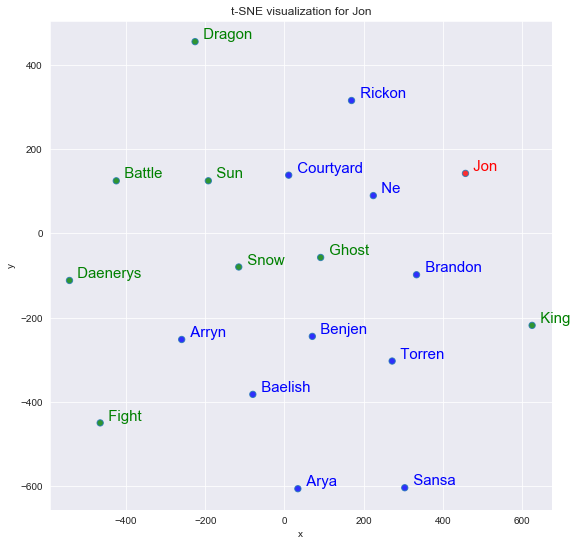

In [31]:
tsnescatterplot(w2v_model, 'jon', ['fight', 'battle', 'sun', 'snow', 'ghost', 'king', 'dragon', 'daenerys']) 

### 10 palavras mais similares VS 10 palavras menos similares

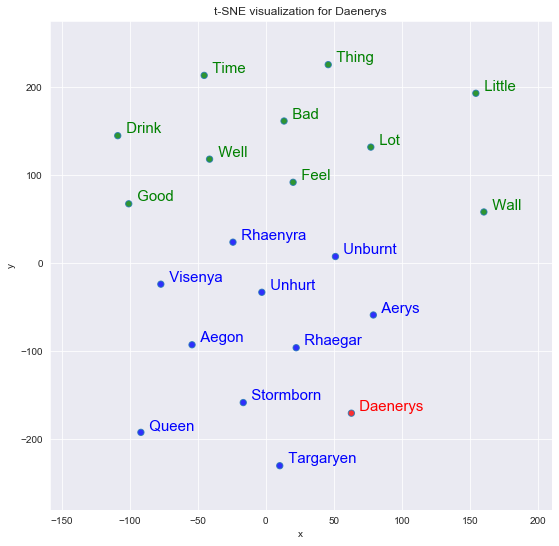

In [32]:
tsnescatterplot(w2v_model, 'daenerys', [i[0] for i in w2v_model.wv.most_similar(negative=["daenerys"])])